In [1]:
# scikit-learn pereptron and adaline implementations
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Other imports
import sys
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
### Reading-in
file_path = '/Users/eliseeldridge/desktop/Machine/Proj1/project_adult.csv'
file_path2 = '/Users/eliseeldridge/desktop/Machine/Proj1/project_validation_inputs.csv'

# read_csv calls:
df_adult = pd.read_csv(file_path, header=0, encoding='utf-8')
df_validation = pd.read_csv(file_path2, header=0, encoding='utf-8')

In [11]:
# Preprocess the dataset: handle missing values, encode categorical features, standardize numerical features, 
# and separate features from target.
def preprocess_data(df, target_column='income', fit_scaler=True, return_split=False, test_size=0.2, random_state=42):
    
    global trained_scaler
    
    print(f"Original data shape: {df.shape}")
    print(f"Original data columns: {df.columns.tolist()}")

    # Handle missing values 
    df.replace('?', np.nan, inplace=True)
    df.dropna(inplace=True)
    
    print(f"After handling missing values shape: {df.shape}")

    # Keep track of rows indexes
    df = df.reset_index(drop=True)

    # SEPARATE X AND y ONLY IF target_column IS PROVIDED AND EXISTS
    if target_column is not None and target_column in df.columns:
        y = df[target_column]
        X = df.drop(columns=[target_column])
        print(f"After separation - X shape: {X.shape}, y shape: {y.shape}")
    else:
        X = df.copy()
        y = None
        print(f"No target column specified or found. Using all columns as features. X shape: {X.shape}")
    
    # Encode categorical features (only on X, not y)
    categorical_cols = X.select_dtypes(include=['object']).columns
    print(f"Categorical columns to encode: {categorical_cols.tolist()}")
    
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    
    print(f"After encoding categorical features shape: {X.shape}")

    # Standardize numerical features
    numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
    
    # Only use columns that actually exist in X
    numeric_cols = [col for col in numeric_cols if col in X.columns]
    print(f"Numeric columns to scale: {numeric_cols}")
    
    if numeric_cols:
        if fit_scaler:
            # For training data - fit and transform
            scaler = StandardScaler()
            X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
            # Save the scaler for later use
            trained_scaler = scaler
            print("Fitted new scaler on training data")
        else:
            # For validation data - transform only using pre-fitted scaler
            if trained_scaler is not None:
                X[numeric_cols] = trained_scaler.transform(X[numeric_cols])
                print("Used pre-fitted scaler")
            else:
                print("Warning: No pre-fitted scaler found. Fitting new one...")
                scaler = StandardScaler()
                X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
                trained_scaler = scaler
    else:
        print("Warning: No numeric columns found for scaling")
    
    # Ensure all columns are numeric
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = pd.to_numeric(X[col], errors='coerce')
    
    # Fill any NaN values
    X = X.fillna(0)
    
    print(f"Final processed features shape: {X.shape}")
    
    if return_split and y is not None:
        # Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        print(f"Train/test split - X_train: {X_train.shape}, X_test: {X_test.shape}")
        return X_train, X_test, y_train, y_test
    elif return_split and y is None:
        raise ValueError("Cannot return split when no target column is available")
    else:
        if y is not None:
            return X, y
        else:
            return X  # Return only X if no target column

In [5]:
# Preprocess and split in one step
X_train, X_test, y_train, y_test = preprocess_data(
    df_adult, 
    target_column='income', 
    fit_scaler=True, 
    return_split=True,
    test_size=0.2,
    random_state=42
)

# Scikit-learn Perceptron
sk_ppn = SklearnPerceptron(eta0=0.1, max_iter=15, random_state=42)
sk_ppn.fit(X_train, y_train)
sk_y_pred_ppn = sk_ppn.predict(X_test)
print(f"Scikit-learn Perceptron accuracy: {accuracy_score(y_test, sk_y_pred_ppn):.4f}")

# Scikit-learn Adaline (using SGDClassifier with 'log_loss' is closer, but 'perceptron' is available)
# For Adaline (which uses GD), SGDClassifier with 'hinge' loss is a good proxy, as it's a linear classifier with regularization
sk_ada = SGDClassifier(loss='perceptron', eta0=0.0001, learning_rate='constant', max_iter=15, random_state=42)
sk_ada.fit(X_train, y_train)
sk_y_pred_ada = sk_ada.predict(X_test)
print(f"Scikit-learn Adaline (SGDClassifier) accuracy: {accuracy_score(y_test, sk_y_pred_ada):.4f}")

Original data shape: (26048, 16)
Original data columns: ['Unnamed: 0', 'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
After handling missing values shape: (24157, 16)
After separation - X shape: (24157, 15), y shape: (24157,)
Categorical columns to encode: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
After encoding categorical features shape: (24157, 97)
Numeric columns to scale: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Fitted new scaler on training data
Final processed features shape: (24157, 97)
Train/test split - X_train: (19325, 97), X_test: (4832, 97)
Scikit-learn Perceptron accuracy: 0.7510
Scikit-learn Adaline (SGDClassifier) accuracy: 0.7510


In [ ]:
# Train Perceptron and Adline models (at least AdalineSGD).
# Find the accuracy of your best models from both algorithms
class Perceptron:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.w_ = None
        self.errors_ = []

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1] + 1)
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)


class AdalineSGD:
    def __init__(self, eta=0.0001, n_iter=50, random_state=1, shuffle=True):
        self.eta = eta  
        self.n_iter = n_iter
        self.random_state = random_state
        self.shuffle = shuffle
        self.w_ = None
        self.cost_ = []

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1] + 1)
        self.cost_ = []
        
        # Standardize features if not already done (crucial for Adaline)
        X_std = (X - X.mean(axis=0)) / X.std(axis=0)
        
        for i in range(self.n_iter):
            if self.shuffle:
                indices = np.random.permutation(len(y))
                X_std, y = X_std[indices], y[indices]
            
            total_cost = 0
            for xi, target in zip(X_std, y):
                output = self.net_input(xi)
                error = target - output
                
                # Gradient clipping to prevent explosion
                error = np.clip(error, -10, 10)
                
                # Update weights
                self.w_[1:] += self.eta * xi * error
                self.w_[0] += self.eta * error
                
                total_cost += 0.5 * error**2
            
            avg_cost = total_cost / len(y)
            self.cost_.append(avg_cost)
            
            # Early stopping if cost starts increasing
            if len(self.cost_) > 1 and self.cost_[-1] > self.cost_[-2] * 10:
                print(f"Early stopping at epoch {i+1} due to cost increase")
                break
                
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        # Standardize test data using training statistics
        X_std = (X - X.mean(axis=0)) / X.std(axis=0)
        return np.where(self.net_input(X_std) >= 0.0, 1, -1)


# Convert labels to numeric (-1, 1)
y_train_numeric = y_train.map({'<=50K': -1, '>50K': 1}).values
y_test_numeric = y_test.map({'<=50K': -1, '>50K': 1}).values

# Convert to numpy arrays (ensure they're float for Adaline)
X_train_array = X_train.values.astype(float)
X_test_array = X_test.values.astype(float)

# Train Perceptron
print("Training Perceptron...")
ppn = Perceptron(eta=0.01, n_iter=50, random_state=42)
ppn.fit(X_train_array, y_train_numeric)

# Train AdalineSGD  
print("Training AdalineSGD...")
ada = AdalineSGD(eta=0.0001, n_iter=50, random_state=42, shuffle=True)  # Smaller eta for Adaline
ada.fit(X_train_array, y_train_numeric)

# Make predictions
y_pred_ppn = ppn.predict(X_test_array)
y_pred_ada = ada.predict(X_test_array)

# Calculate accuracies
acc_ppn = np.mean(y_pred_ppn == y_test_numeric)
acc_ada = np.mean(y_pred_ada == y_test_numeric)

print(f"Perceptron accuracy: {acc_ppn:.4f}")
print(f"AdalineSGD accuracy: {acc_ada:.4f}")

Training Perceptron...
Training AdalineSGD...
Perceptron accuracy: 0.7508
AdalineSGD accuracy: 0.7512


/var/folders/79/j6vp4t6n25sdc7mwvq7cqs7m0000gn/T/ipykernel_72532/2894840896.py:84: RuntimeWarning: invalid value encountered in divide
  X_std = (X - X.mean(axis=0)) / X.std(axis=0)


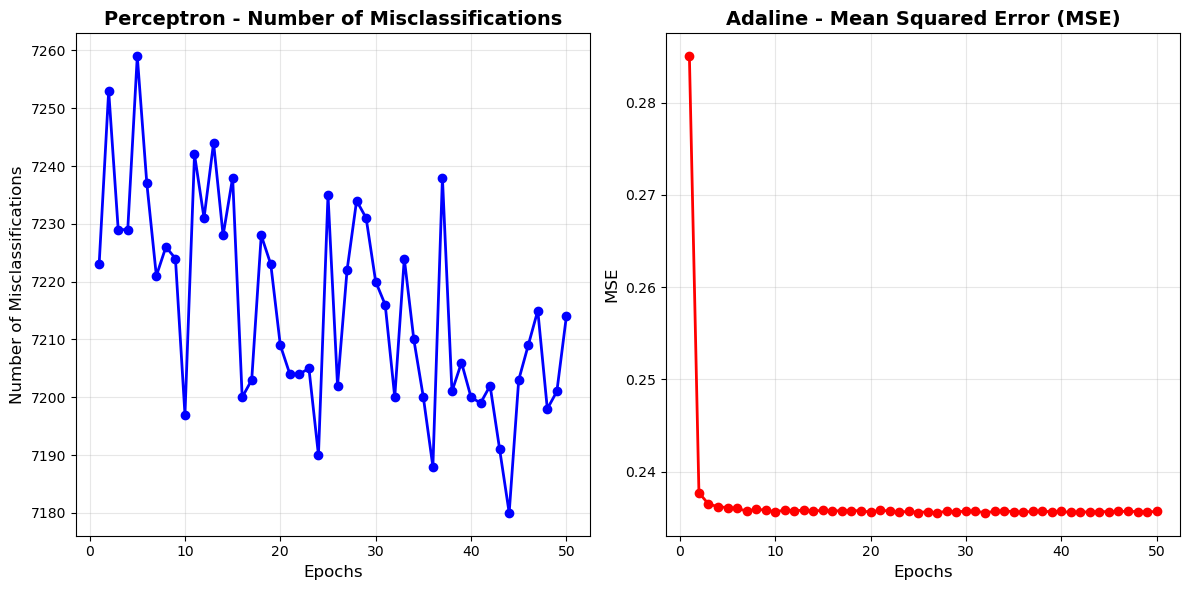

Final Perceptron misclassifications: 7214
Final Adaline MSE: 0.235674
Perceptron converged: No


In [7]:
# Plotting the number of misclassifications (Perceptron) and MSE (Adaline) over epochs
plt.figure(figsize=(12, 6))

# Perceptron misclassifications
plt.subplot(1, 2, 1)
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o', color='blue', linewidth=2)
plt.title('Perceptron - Number of Misclassifications', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Number of Misclassifications', fontsize=12)
plt.grid(True, alpha=0.3)

# Adaline MSE
plt.subplot(1, 2, 2)
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o', color='red', linewidth=2)
plt.title('Adaline - Mean Squared Error (MSE)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final values
print(f"Final Perceptron misclassifications: {ppn.errors_[-1]}")
print(f"Final Adaline MSE: {ada.cost_[-1]:.6f}")
print(f"Perceptron converged: {'Yes' if ppn.errors_[-1] == 0 else 'No'}")

In [8]:
# Use best performing models to predict outputs for project_validation_inputs.
# Preprocess the validation data for prediction
X_validation = preprocess_data(
    df_validation, 
    target_column=None,
    fit_scaler=False,
    return_split=False
)

# Fix feature alignment
expected_features = sk_ppn.feature_names_in_
missing_features = set(expected_features) - set(X_validation.columns)

for feature in missing_features:
    X_validation[feature] = 0

X_validation = X_validation[expected_features]

# Make predictions
perceptron_predictions = sk_ppn.predict(X_validation)
adaline_predictions = sk_ada.predict(X_validation)

# Create results with original data for context
results_df = df_validation.copy().reset_index(drop=True)
results_df['Perceptron_Prediction'] = perceptron_predictions
results_df['Adaline_Prediction'] = adaline_predictions
results_df['Models_Agree'] = results_df['Perceptron_Prediction'] == results_df['Adaline_Prediction']

Original data shape: (6513, 15)
Original data columns: ['Unnamed: 0', 'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
After handling missing values shape: (6005, 15)
No target column specified or found. Using all columns as features. X shape: (6005, 15)
Categorical columns to encode: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
After encoding categorical features shape: (6005, 95)
Numeric columns to scale: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Used pre-fitted scaler
Final processed features shape: (6005, 95)


In [9]:
# Display detailed prediction results
# Find the accuracy on the validation data using your best models for both.
print("PREDICTION RESULTS FOR VALIDATION DATA")
print("=" * 60)
print(f"Total predictions made: {len(results_df):,}")
print(f"Models agree on: {results_df['Models_Agree'].sum():,} samples")
print(f"Models disagree on: {len(results_df) - results_df['Models_Agree'].sum():,} samples")

print("\n" + "=" * 40)
print("PREDICTION DISTRIBUTION")
print("=" * 40)
print("PERCEPTRON MODEL:")
print(results_df['Perceptron_Prediction'].value_counts())
print(f"Ratio: {(results_df['Perceptron_Prediction'] == '>50K').mean():.3f}")

print("\nADALINE MODEL:")
print(results_df['Adaline_Prediction'].value_counts())
print(f"Ratio: {(results_df['Adaline_Prediction'] == '>50K').mean():.3f}")

print("\n" + "=" * 40)
print("DETAILED SAMPLE PREDICTIONS")
print("=" * 40)
print("First 20 predictions with context:")
sample_cols = ['age', 'workclass', 'education', 'occupation', 'hours-per-week', 
               'Perceptron_Prediction', 'Adaline_Prediction', 'Models_Agree']
print(results_df[sample_cols].head(20).to_string(index=False))

print("\n" + "=" * 40)
print("CASES WHERE MODELS DISAGREE")
print("=" * 40)
disagreements = results_df[~results_df['Models_Agree']]
if not disagreements.empty:
    print(f"Models disagree on {len(disagreements)} cases:")
    print(disagreements[sample_cols].to_string(index=False))
else:
    print("Perfect agreement between models!")

print("\n" + "=" * 40)
print("PERFORMANCE SUMMARY (Based on Test Data)")
print("=" * 40)
print("Note: Validation accuracy cannot be calculated without true labels")
print(f"Perceptron Test Accuracy: {accuracy_score(y_test, sk_y_pred_ppn):.4f}")
print(f"Adaline Test Accuracy:    {accuracy_score(y_test, sk_y_pred_ada):.4f}")

# Show training data distribution for comparison
print(f"\nTraining data distribution:")
print(f"<=50K: {14518} samples ({(14518/(14518+4807)):.1%})")
print(f">50K:  {4807} samples ({(4807/(14518+4807)):.1%})")


PREDICTION RESULTS FOR VALIDATION DATA
Total predictions made: 6,005
Models agree on: 6,004 samples
Models disagree on: 1 samples

PREDICTION DISTRIBUTION
PERCEPTRON MODEL:
<=50K    6003
>50K        2
Name: Perceptron_Prediction, dtype: int64
Ratio: 0.000

ADALINE MODEL:
<=50K    6004
>50K        1
Name: Adaline_Prediction, dtype: int64
Ratio: 0.000

DETAILED SAMPLE PREDICTIONS
First 20 predictions with context:
 age        workclass    education        occupation  hours-per-week Perceptron_Prediction Adaline_Prediction  Models_Agree
  27          Private Some-college      Adm-clerical              38                 <=50K              <=50K          True
  45        State-gov      HS-grad   Exec-managerial              40                 <=50K              <=50K          True
  29          Private    Bachelors   Exec-managerial              55                 <=50K              <=50K          True
  30          Private    Bachelors Machine-op-inspct              40                 <=5

In [10]:
# Quick check: Look at the 1-2 people predicted as >50K
high_income_predictions = results_df[
    (results_df['Perceptron_Prediction'] == '>50K') | 
    (results_df['Adaline_Prediction'] == '>50K')
]

print("Individuals predicted as >50K:")
print(high_income_predictions[['age', 'education', 'occupation', 'capital-gain', 
                              'hours-per-week', 'Perceptron_Prediction', 'Adaline_Prediction']].to_string(index=False))

Individuals predicted as >50K:
 age   education     occupation  capital-gain  hours-per-week Perceptron_Prediction Adaline_Prediction
  47 Prof-school Prof-specialty             0              60                  >50K              <=50K
  31     Masters Prof-specialty         14084              50                  >50K               >50K
